In [2]:
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import multiprocessing as mp

from tqdm import tqdm
from itertools import product

from pathlib import Path
import numpy.typing as npt

def imread(fn):
    return np.array(Image.open(fn)).astype(np.float32) / 255

In [3]:
BASEPATH = Path("../data")
TRAINPATH = BASEPATH / "train_v2"
TESTPATH = BASEPATH / "test_v2"

In [4]:
train_files = list(TRAINPATH.iterdir())
test_files = list(TESTPATH.iterdir())

In [5]:
train_df = pd.read_csv(BASEPATH / "train_ship_segmentations_v2.csv")
submission_df = pd.read_csv(BASEPATH / "sample_submission_v2.csv")

In [6]:
train_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [7]:
train_df.describe()

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [9]:
train_df = train_df.dropna()

In [10]:
def rle2mask(rle: str, h: int, w: int) -> npt.ArrayLike:
    total = h * w
    out = np.zeros(total, dtype=int)
    if isinstance(rle, str):
        rle_list = rle.split(" ")
        starts = [int(x) for x in rle_list[::2]]
        lengths = [int(x) for x in rle_list[1::2]]

        for start, length in zip(starts, lengths):
            out[start:(start + length)] = 1
    return out.reshape((h, w)).T

def id2mask(image_id: str, df: pd.DataFrame, h: int, w: int) -> npt.ArrayLike:
    rles = df.query(f"ImageId == '{image_id}'")["EncodedPixels"]
    mask = np.sum([rle2mask(rle, H, W) for rle in rles], axis=0)
    return mask

def mask2rle(mask: npt.ArrayLike) -> str:
    h, w = mask.shape
    long = mask.T.reshape(h * w)
    diff = np.diff(long)
    nzdiff = np.nonzero(diff)[0]
    starts = nzdiff[::2] + 1
    lengths = np.diff(nzdiff)[::2]
    rle = " ".join([str(s) + " " + str(l) for s, l in zip(starts, lengths)])
    return rle

In [11]:
im0 = train_df.iloc[0]
fn = im0["ImageId"]
img = imread(TRAINPATH / fn)
H, W, C = img.shape

mask = id2mask(fn, train_df, H, W)

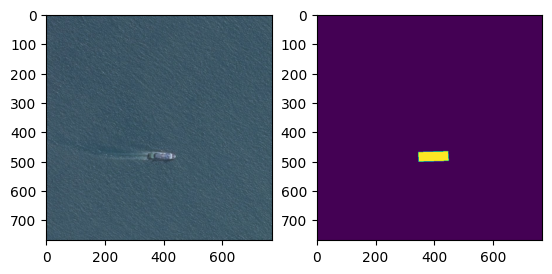

In [12]:
f, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(mask)

In [13]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

class ShipDataset(Dataset):
    def __init__(self, df, transforms=None, split=None, basepath=TRAINPATH):
        ids = df["ImageId"].unique().tolist()
        if split is not None:
            assert split in ["train", "test"], "split must be either ['train', 'test']"
            train, test = train_test_split(ids, random_state=0)
            ids = train if split == "train" else test
        
        self.ids = ids
        self.df = df.query(f"ImageId in {ids}")
        self.transforms = transforms
        self.basepath = basepath
            
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, ix):
        image_id = self.ids[ix]
        rles = self.df.query(f"ImageId == '{image_id}'")["EncodedPixels"]
        img = Image.open(self.basepath / image_id)
        mask = np.sum([rle2mask(rle, H, W) for rle in rles], axis=0)
        #mask = np.where(mask > 1, 1, mask)
        if self.transforms:
            img, mask = self.transforms(img, mask)
        return img, mask


In [14]:
import random
from torchvision import transforms as T
from torchvision.transforms import functional as F


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        image = F.resize(image, self.size, antialias=True)
        target = F.resize(target[None,...], self.size, interpolation=T.InterpolationMode.NEAREST)
        return image, target[0]


class RandomHorizontalFlip:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = F.hflip(image)
            target = F.hflip(target)
        return image, target
    
class RandomVerticalFlip:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = F.vflip(image)
            target = F.vflip(target)
        return image, target


class RandomCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        crop_params = T.RandomCrop.get_params(image, (self.size, self.size))
        image = F.crop(image, *crop_params)
        target = F.crop(target, *crop_params)
        return image, target


class PILToTensor:
    def __call__(self, image, target=None):
        image = F.pil_to_tensor(image)
        if target is not None:
            target = torch.as_tensor(np.array(target), dtype=torch.float32)
        return image, target


class ToDtype:
    def __init__(self, dtype, scale=False):
        self.dtype = dtype
        self.scale = scale

    def __call__(self, image, target):
        if not self.scale:
            return image.to(dtype=self.dtype), target
        image = F.convert_image_dtype(image, self.dtype)
        return image, target


class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

In [15]:
transforms = Compose([
    PILToTensor(),
    Resize(256),
    ToDtype(torch.float32, scale=True),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [16]:
from torch import optim
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, deeplabv3_mobilenet_v3_large

device = "cuda" if torch.cuda.is_available() and True else "cpu"
print(device)

cuda


In [17]:
def new_model(device):
    model = lraspp_mobilenet_v3_large(num_classes=1).float().to(device)
    for params in model.backbone.parameters():
        params.requires_grad = False
    return model

def train_model(model, dl, epoch, lr, device):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=lr,
        epochs=epoch,
        steps_per_epoch=len(dl)
    )

    loser = nn.BCEWithLogitsLoss()

    # train
    losses = []
    for _ in tqdm(range(epoch)):
        for image, mask in dl:
            image = image.to(device)
            mask = mask[:,None,:,:].to(device)

            pred = model(image)["out"]
            loss = loser(pred, mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            losses += [loss.item()]
    return losses

def validate_model(model, tl, device):
    model.eval()
    loser = MixedLoss(10.0, 2.0)
    val_loss = 0
    n = 0
    with torch.no_grad():
        for image, mask in tl:
            image = image.to(device)
            mask = mask[:,None,:,:].to(device)

            pred = model(image)["out"]
            val_loss += loser(pred, mask).item() * image.shape[0]
            n += image.shape[0]
    
    return val_loss / n

def save_model(model, pth):
    model.cpu()
    torch.save(model.state_dict(), pth)

def load_model(pth):
    model = lraspp_mobilenet_v3_large(num_classes=1).float()
    model.load_state_dict(torch.load(pth))
    model.eval()
    return model
    

In [18]:
if False:
    # cross validation
    ds = ShipDataset(train_df, transforms=transforms, split="train")
    dl = DataLoader(ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

    ts = ShipDataset(train_df, transforms=transforms, split="test")
    tl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    lrs = [1e-1, 1e-2]
    epochs = [5, 10, 15]
    params = [
        (1e-1, 1),
        (1e-2, 1),
        (1e-2, 15),
        (1e-3, 1),
        (1e-3, 15)
    ]

    res = {}

    for lr, epoch in tqdm(params):
        model = new_model(device)
        train_model(model, dl, epoch, lr, device)

        # validate
        val_loss = validate_model(model, tl, device)
        res[(lr, epoch)] = val_loss
        print(f"lr: {lr} for {epoch} epochs = {val_loss} loss")

    # get best fit params
    min_loss = float("inf")
    for k in res:
        if res[k] < min_loss:
            lr, epoch = k
            min_loss = res[k]

    print(f"training w/ lr: {lr} for {epoch} epochs")
else:
    epoch = 1
    lr = 1e-2

In [19]:
# full run
rds = ShipDataset(train_df)
ds = ShipDataset(train_df, transforms=transforms)
dl = DataLoader(ds, batch_size=32, shuffle=True, num_workers=12, pin_memory=True)

In [20]:
ds[0][1].shape

torch.Size([256, 256])

In [21]:
model = new_model(device)
losses = train_model(model, dl, epoch, lr, device)

100%|██████████| 1/1 [05:55<00:00, 355.61s/it]


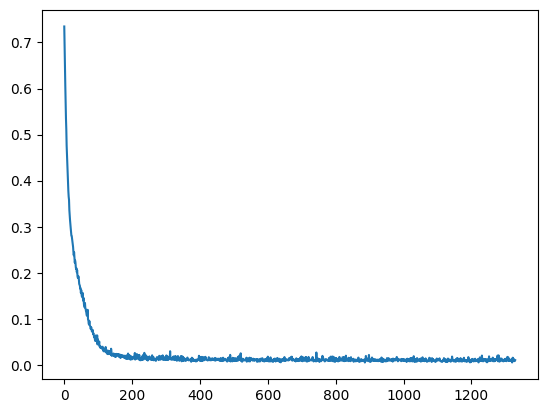

In [22]:
plt.plot(losses)

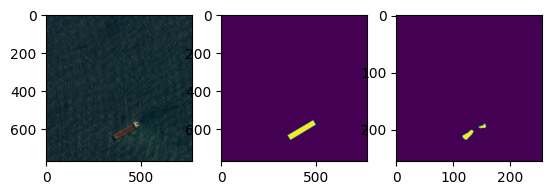

In [46]:
ix = 1091
image_, mask_ = rds[ix]
image, mask = ds[ix]
image, mask = image[None,...].to(device), mask[None,...].to(device)
model.eval()
with torch.no_grad():
    pred = model(image)
    
f, ax = plt.subplots(1, 3)
ax[0].imshow(image_)
ax[1].imshow(mask_)
ax[2].imshow(pred["out"][0,0,...].cpu().numpy() > 0)

In [47]:
save_model(model, "../models/model.pt")

In [ ]:
submission_df

In [ ]:
ds = ShipDataset(submission_df, transforms=transforms, basepath=TESTPATH)
dl = DataLoader(ds, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
model.eval()
rles = []
with torch.no_grad():
    for image, mask in tqdm(dl):
        image = image.to(device)
        preds = model(image)["out"].cpu().numpy()
        rles += [
            mask2rle(
                1 * (pred[0,:,:] > 0)
            )
            for pred in preds
        ]
        

In [ ]:
submission_df["EncodedPixels"] = rles

In [ ]:
submission_df.head()

In [ ]:
submission_df.to_csv("submission.csv", index=False)